In [1]:
import tensorflow as tf
from tensorflow import keras
from keras import backend as K

from tensorflow.keras.preprocessing.image import img_to_array, array_to_img, load_img

import numpy as np
import pandas as pd

import matplotlib.pyplot as plt
import cv2

In [2]:
def dice_coef_9cat(y_true, y_pred, smooth=1e-7):
    '''
    Dice coefficient for 10 categories. Ignores background pixel label 0
    Pass to model as metric during compile statement
    '''
    y_true_f = K.flatten(K.one_hot(K.cast(y_true, 'int32'), num_classes=3)[...,1:])
    y_pred_f = K.flatten(y_pred[...,1:])
    intersect = K.sum(y_true_f * y_pred_f, axis=-1)
    denom = K.sum(y_true_f + y_pred_f, axis=-1)
    return K.mean((2. * intersect / (denom + smooth)))

def dice_coef_9cat_loss(y_true, y_pred):
    '''
    Dice loss to minimize. Pass to model as loss during compile statement
    '''
    return 1 - dice_coef_9cat(y_true, y_pred)

In [3]:
loss = dice_coef_9cat_loss
model = keras.models.load_model('../input/origalist/working_model.h5', 
                                   custom_objects={ loss.__name__: loss })

In [4]:
def remove_nerves(image):
    img = array_to_img(image)
    
    img = cv2.cvtColor(np.array(img), cv2.COLOR_BGR2RGB)
    # convert image to grayScale
    grayScale = cv2.cvtColor(img, cv2.COLOR_RGB2GRAY)
   
    # kernel for morphologyEx
    kernel = cv2.getStructuringElement(1,(17,17))
   
    # apply MORPH_BLACKHAT to grayScale image
    blackhat = cv2.morphologyEx(grayScale, cv2.MORPH_BLACKHAT, kernel)
  
    # apply thresholding to blackhat
    _,threshold = cv2.threshold(blackhat,10,255,cv2.THRESH_BINARY)

    # inpaint with original image and threshold image
    final_image = cv2.inpaint(img,threshold,1,cv2.INPAINT_TELEA)
    final_image = cv2.cvtColor(final_image, cv2.COLOR_BGR2RGB)
    
    return final_image.astype(np.float64)/255.0

## Crop The Image

According the research done in the paper below, cropping the fundus image near the optic disc has clinical reason. Research has shown that Glaucoma mainly affects the optic disc and its nearby surroundings. 

> Diaz-Pinto, A., Morales, S., Naranjo, V. et al. CNNs for automatic glaucoma assessment using fundus images: an extensive validation. BioMed Eng OnLine 18, 29 (2019). https://doi.org/10.1186/s12938-019-0649-y

These images are cropped based off the segmentation predictions. They were trained using the 650 images and segmentation labels from ORIGA dataset. After finding the center of the optic disc based off the predicted mask, the algorithm returns a cropped region of size 400x400 around the center point. 

In [5]:
def get_cropped_image(file, model):
    test_img = load_img(file, target_size=(512, 512))
    test_img_original = load_img(file)
    full_arr = np.array(test_img_original)/255.0
    x_true = full_arr.shape[0]
    y_true = full_arr.shape[1]
    test_arr = img_to_array(test_img)/255.0
    
    test_arr_preprocessed = remove_nerves(test_arr)

    pred = model.predict(test_arr_preprocessed.reshape(1, 512, 512, 3))
    single_pred = pred[0]
    mask_img = array_to_img(single_pred)
    mask_img = mask_img.resize((y_true, x_true))
    mask_arr = np.array(mask_img)/255.0
    my_mask = np.zeros((x_true, y_true))
    marked = []
    inner = []
    for i in range(x_true):
        for j in range(y_true):
            if np.argmax(mask_arr[i][j]) != 0:
                marked.append([i, j])
                
    avgi = []
    avgj = []
    for lis in marked:
        first = lis[0]
        sec = lis[1]
        avgi.append(first)
        avgj.append(sec)
        

        
    avgi = sum(avgi)//len(avgi)
    avgj = sum(avgj)//len(avgj)
    
    middle  = (avgi, avgj)
    
    top = middle[1] - 200
    bottom = middle[1] + 200
    left = middle[0] - 200
    right = middle[0] + 200
    
    cropped = test_img_original.crop(((top, left, bottom, right)))
    plt.title("Cropped Image")
    plt.imshow(cropped)
    plt.show()
    
    return np.array(cropped)/255.0
    

## Test Image

The test example below shows one image taken from the BinRushed folder. This data was aquired from the Deep Blue database offered by University of Michigan. 

From this single test example, we can see the the algorithm accuratly identifies the optic disc and its surrounding. 

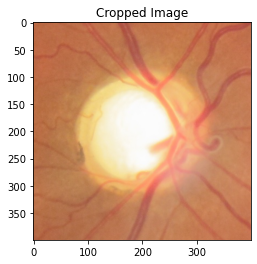

In [6]:
test_file = '../input/origalist/BinRushed/BinRushed/BinRushed2/image18prime.jpg'
cropped_img = get_cropped_image(test_file, model)